In [1]:
import tensorflow as tf
import os
from PIL import Image
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import autoencoder


class UNetUpscaling(models.Model):

    def __init__(self,  **kwargs):

        super(UNetUpscaling, self).__init__(**kwargs)

        self.unit1 = tf.keras.Sequential([
            layers.Conv2D(32, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(32, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2DTranspose(32, 2, strides=2, padding='same')
        ])

        self.unit2 = tf.keras.Sequential([
            layers.Conv2D(16, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2D(16, 3, padding='same'),
            layers.ReLU(),
            layers.Conv2DTranspose(16, 2, strides=2, padding='same')
        ])

        self.unit3 = tf.keras.Sequential([
            layers.Conv2D(3, 3, strides=2, padding='same'),
            layers.ReLU()
        ])


    def call(self, inputs):
        x1 = self.unit1(inputs)
        x2 = self.unit2(x1)
        x3 = self.unit3(x2)
        return x3

2024-05-02 00:29:42.338438: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
data_path = './data/minibatch'
HR_path = os.path.join(data_path, 'HR')
LR_path = os.path.join(data_path, 'LR')

INPUT_SHAPE = (None, 50, 50, 3)
NUM_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 0.001
TRAIN_TEST_SPLIT = 0.8
SEED = 42

def hr_to_lr(hr_name):
    """
    000001_patch_0000.png to 000001x2_patch_0000.png
    """
    hr_name = hr_name.split('_')
    hr_name[0] += 'x2'
    return '_'.join(hr_name)

def load_and_preprocess_image(x_path, y_path):
    def load_image(file_path):
        img = tf.io.read_file(file_path)
        img = tf.image.decode_png(img, channels=3)
        img = tf.image.convert_image_dtype(img, tf.float32)
        return img
    return load_image(x_path), load_image(y_path)

hr_files = os.listdir(HR_path)
lr_files = [hr_to_lr(_) for _ in hr_files]

hr_files = [os.path.join(HR_path, _) for _ in hr_files]
lr_files = [os.path.join(LR_path, _) for _ in lr_files]

split_idx = int(len(hr_files) * TRAIN_TEST_SPLIT)
train_lr_files, train_hr_files = lr_files[:split_idx], hr_files[:split_idx]
test_lr_files, test_hr_files = lr_files[split_idx:], hr_files[split_idx:]

train_ds= tf.data.Dataset.from_tensor_slices((train_lr_files, train_hr_files))
test_ds = tf.data.Dataset.from_tensor_slices((test_lr_files, test_hr_files))

train_ds = train_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

tf.random.set_seed(SEED)
train_ds = train_ds.shuffle(buffer_size=1024).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2024-05-02 00:29:44.521525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [10052]
	 [[{{node Placeholder/_1}}]]
2024-05-02 00:29:44.521774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [10052]
	 [[{{node Placeholder/_1}}]]


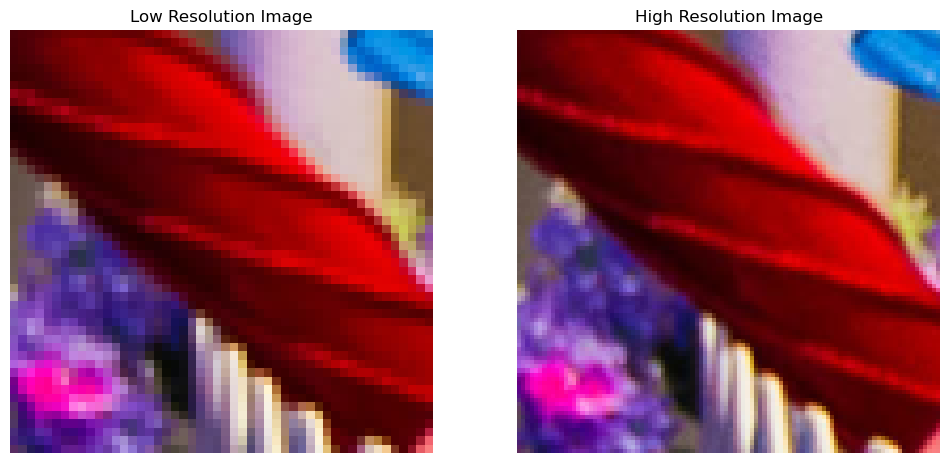

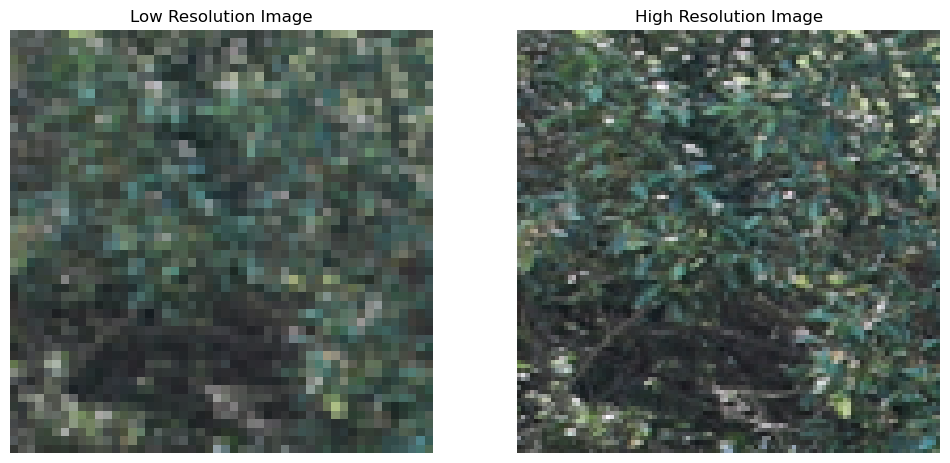

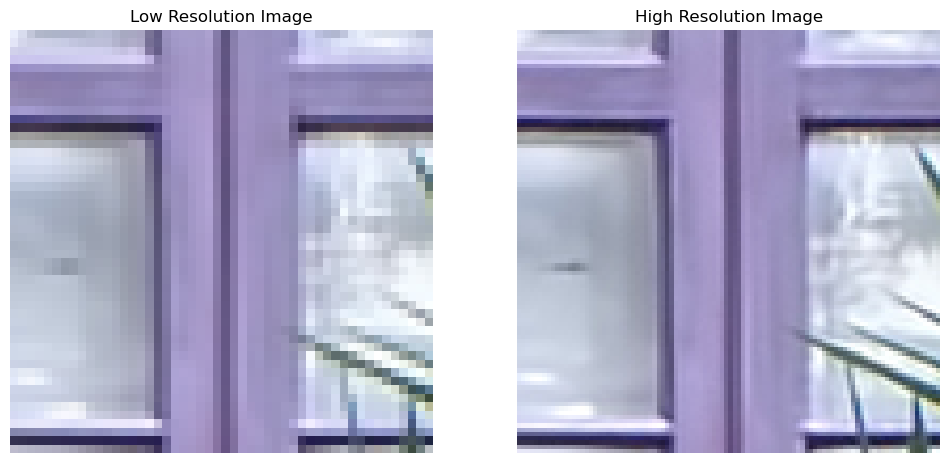

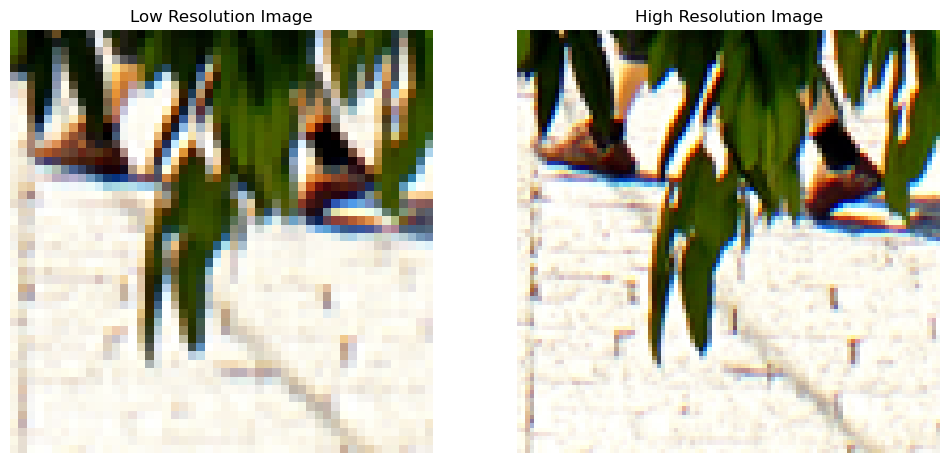

In [3]:
for lr_images, hr_images in train_ds.take(4):
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.title('Low Resolution Image')
    plt.imshow(lr_images[0])
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title('High Resolution Image')
    plt.imshow(hr_images[0])
    plt.axis('off')
    
    plt.show()

In [4]:
# model = UNetUpscaling()
model = autoencoder.SuperResolutionAutoencoder()
model.compile(optimizer='adam', loss='mean_squared_error')
model.build(input_shape=INPUT_SHAPE)
print(model.summary())
model.fit(train_ds, epochs=NUM_EPOCHS, validation_data=test_ds)

Model: "super_resolution_autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             multiple                  1792      
                                                                 
 conv2d_1 (Conv2D)           multiple                  36928     
                                                                 
 max_pooling2d (MaxPooling2D  multiple                 0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           multiple                  73856     
                                                                 
 conv2d_3 (Conv2D)           multiple                  147584    
                                                                 
 max_pooling2d_1 (MaxPooling  multiple                 0         
 2D)                                  

2024-05-02 00:29:47.383284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [10052]
	 [[{{node Placeholder/_1}}]]
2024-05-02 00:29:47.383512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [10052]
	 [[{{node Placeholder/_1}}]]


315/315 [==============================] - ETA: 0s - loss: 0.5146

2024-05-02 00:34:18.309339: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2513]
	 [[{{node Placeholder/_1}}]]
2024-05-02 00:34:18.309503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype string and shape [2513]
	 [[{{node Placeholder/_1}}]]


315/315 [==============================] - 290s 916ms/step - loss: 0.5146 - val_loss: 0.2539
Epoch 2/5
315/315 [==============================] - 293s 930ms/step - loss: 0.2525 - val_loss: 0.2539
Epoch 3/5
315/315 [==============================] - 294s 932ms/step - loss: 0.2524 - val_loss: 0.2539
Epoch 4/5
315/315 [==============================] - 296s 940ms/step - loss: 0.2525 - val_loss: 0.2539
Epoch 5/5
315/315 [==============================] - 285s 904ms/step - loss: 0.2525 - val_loss: 0.2539


In [5]:
a = iter(test_ds)

next(a)
x_samples, y_samples = next(a)
y_pred = model.predict(x_samples)

1/1 [==============================] - 0s 388ms/step


/var/folders/qb/59nvnkb11_n1tqhf4ccx8nc40000gn/T/ipykernel_61127/1578373123.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12, 6))


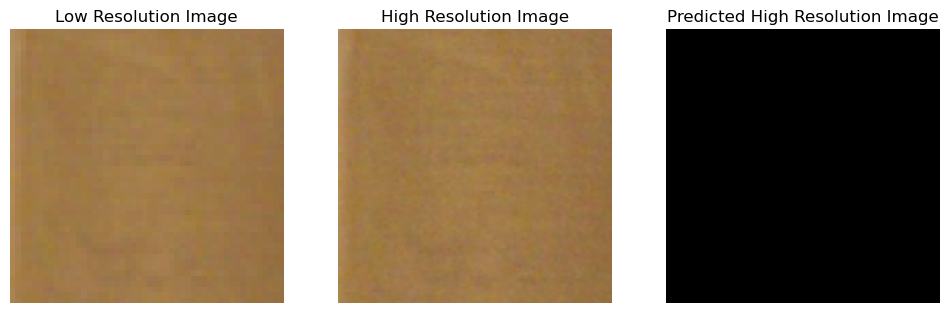

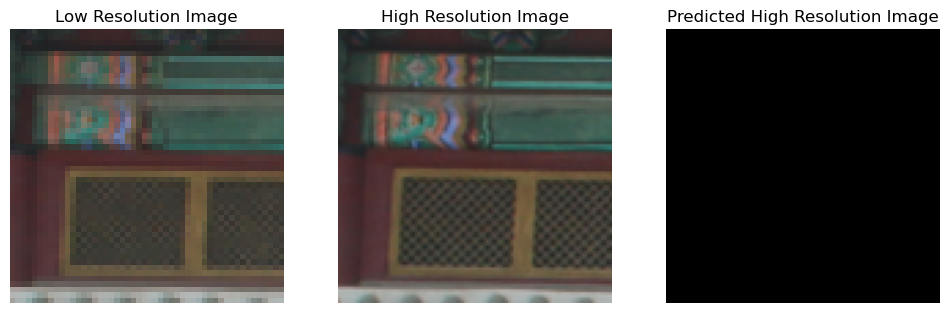

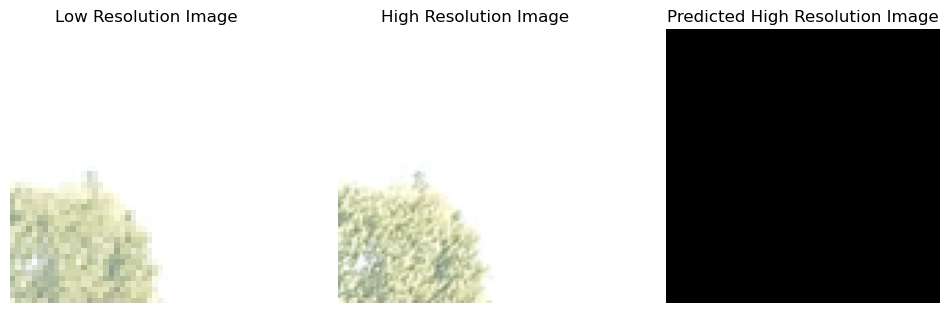

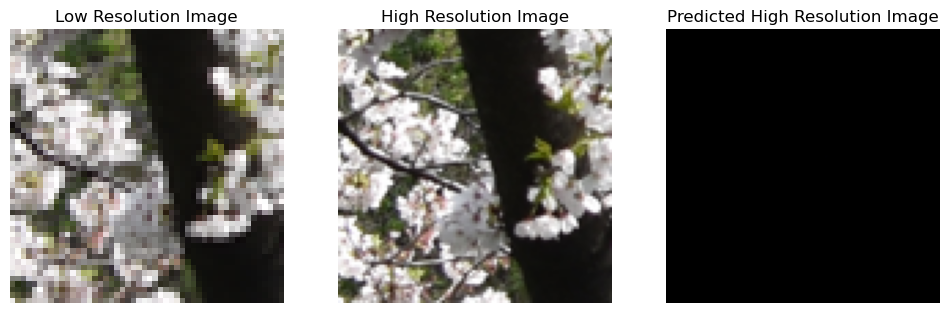

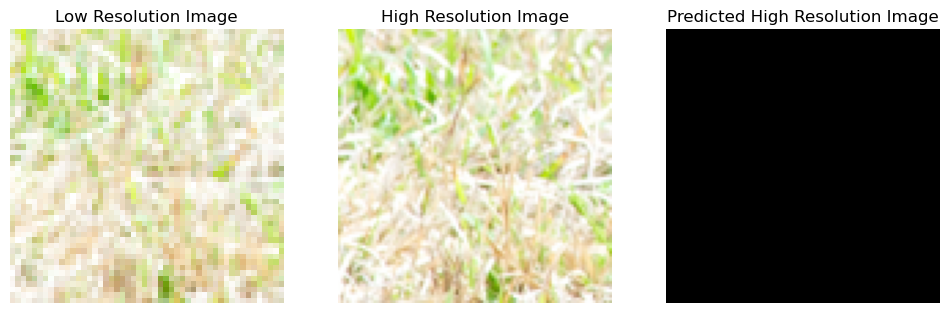

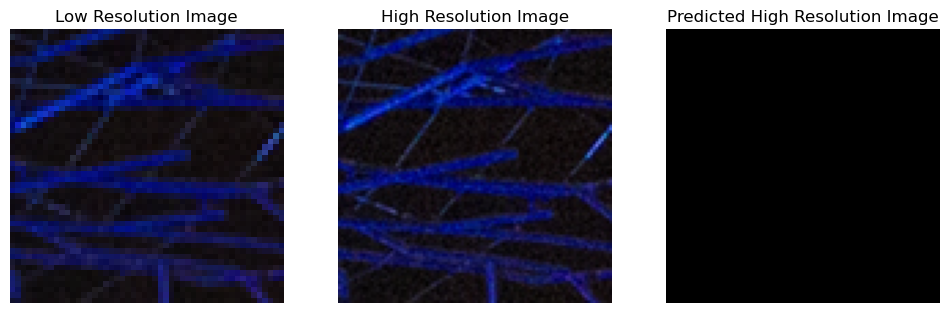

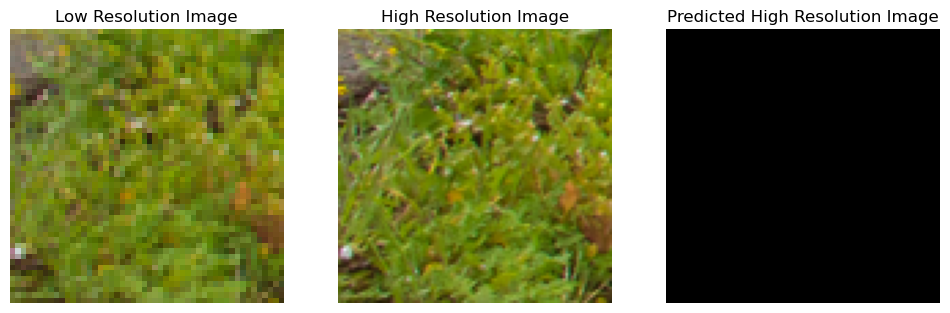

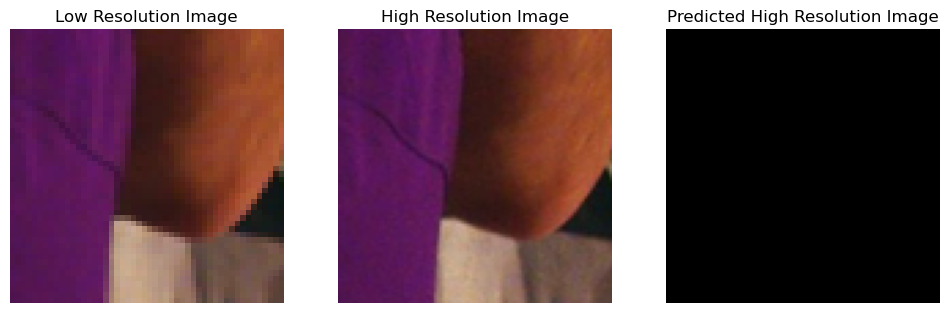

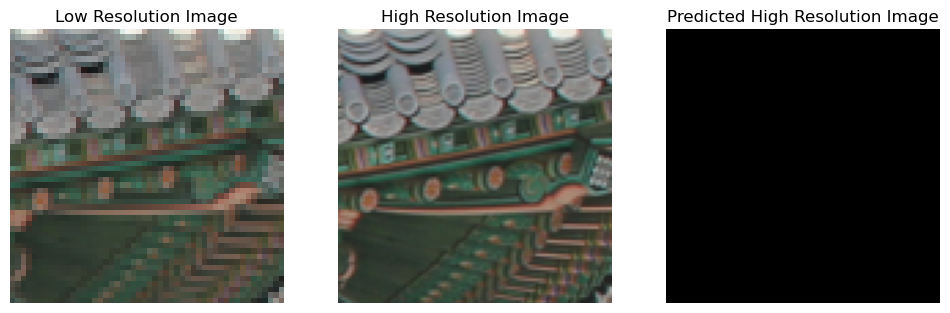

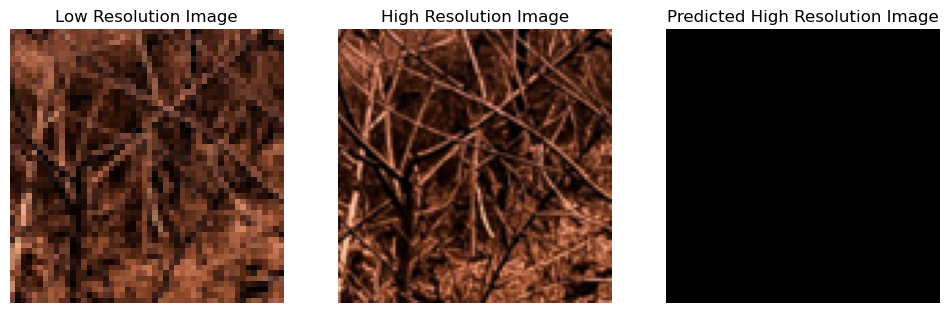

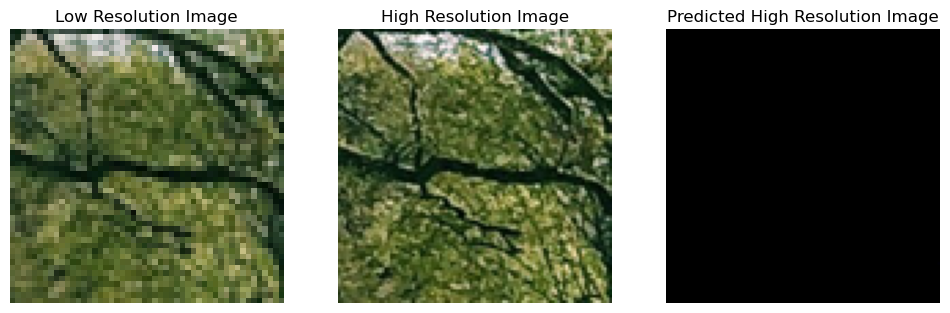

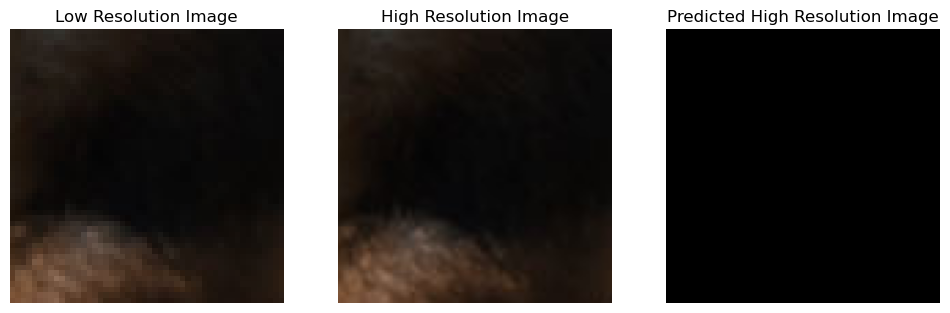

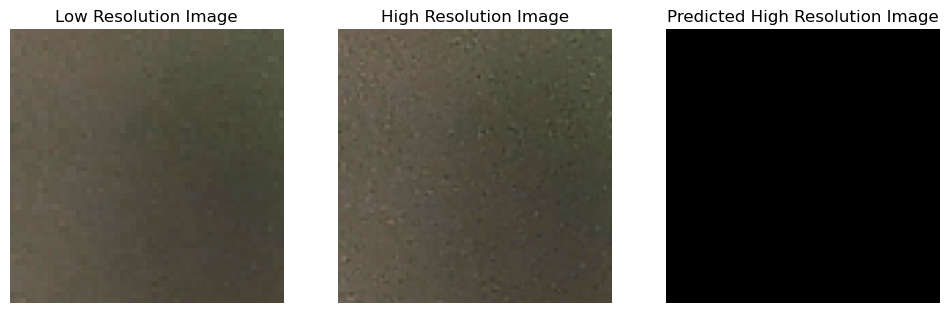

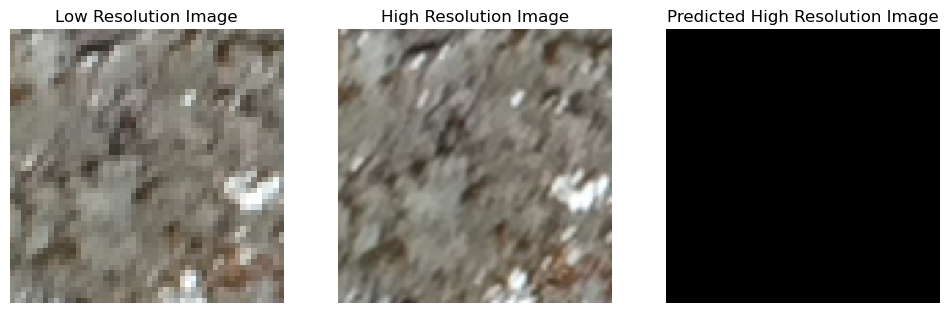

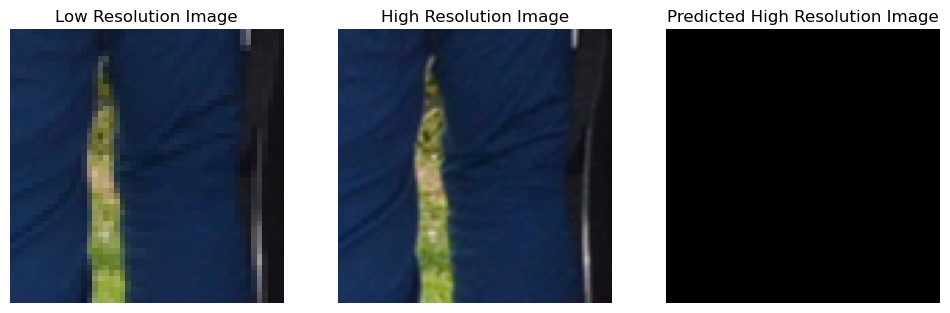

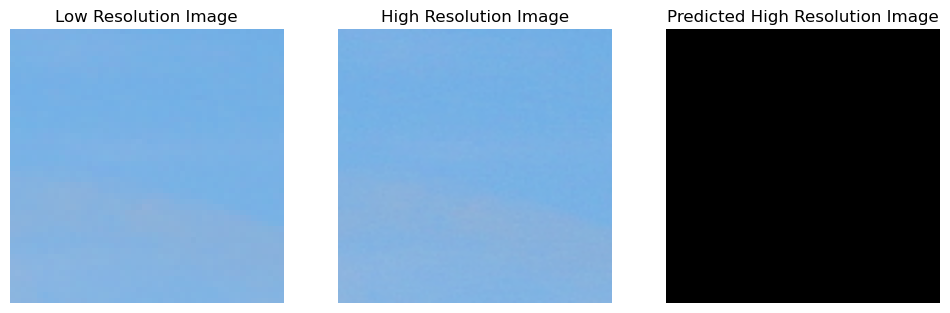

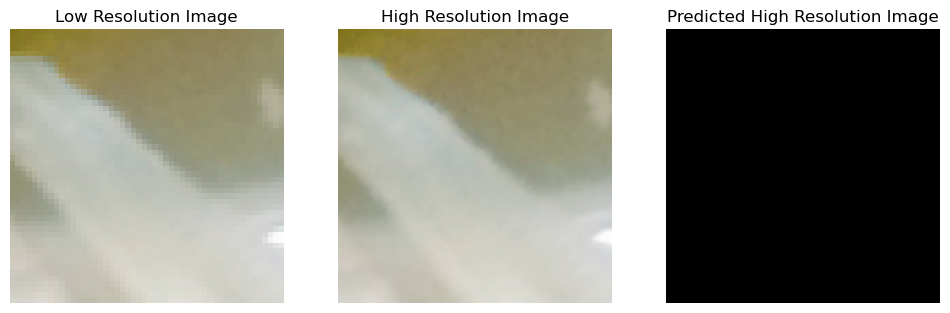

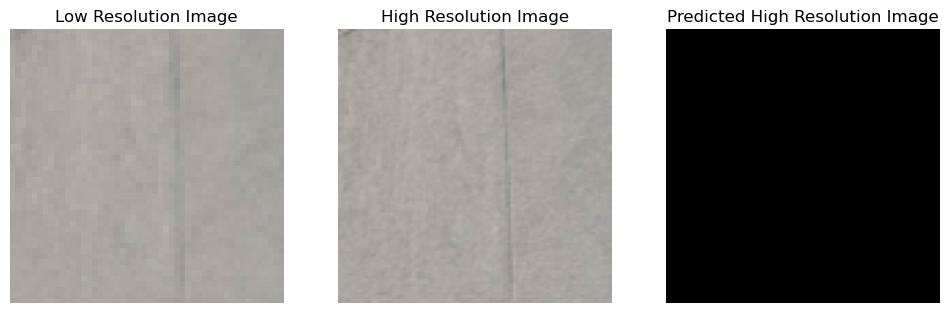

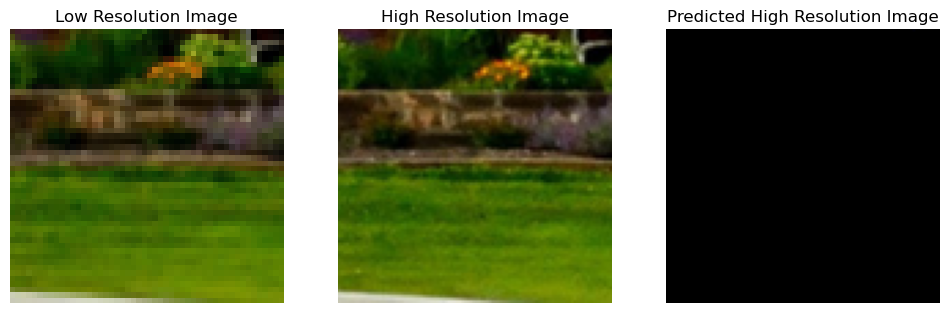

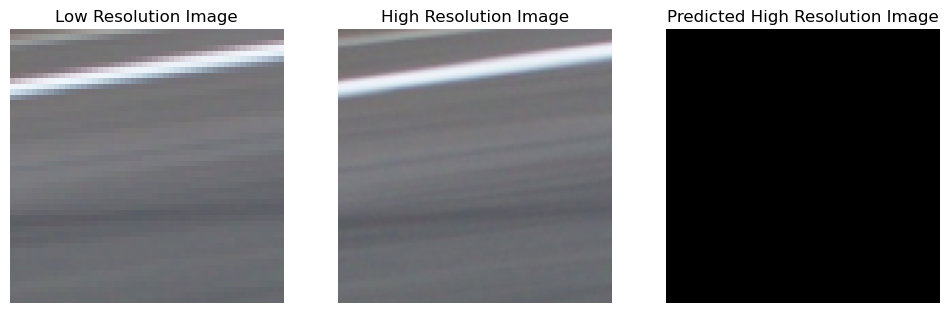

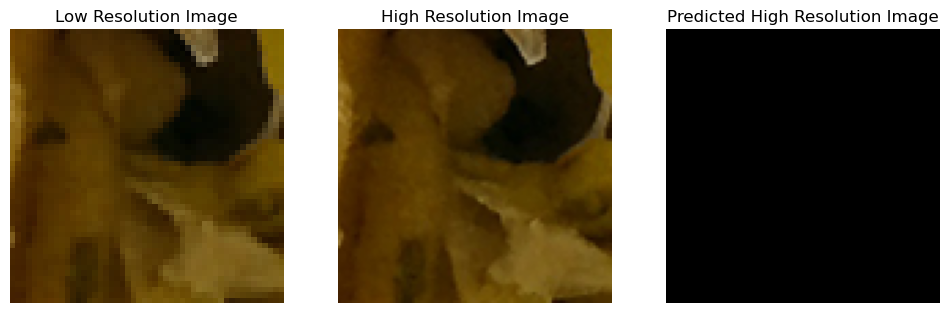

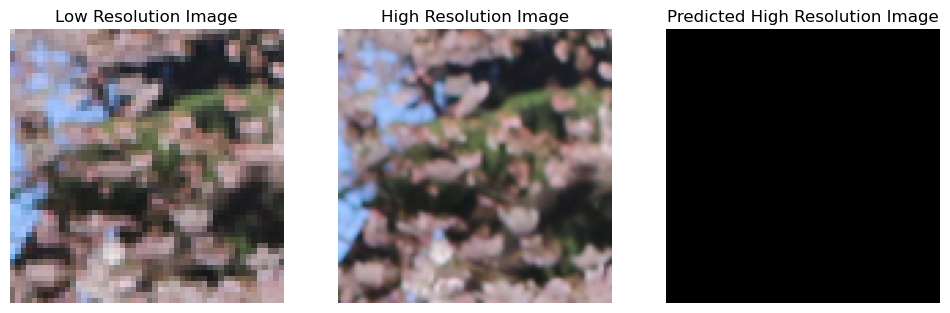

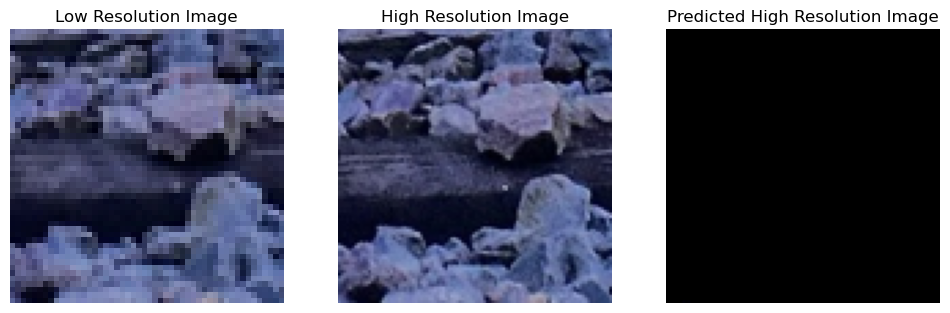

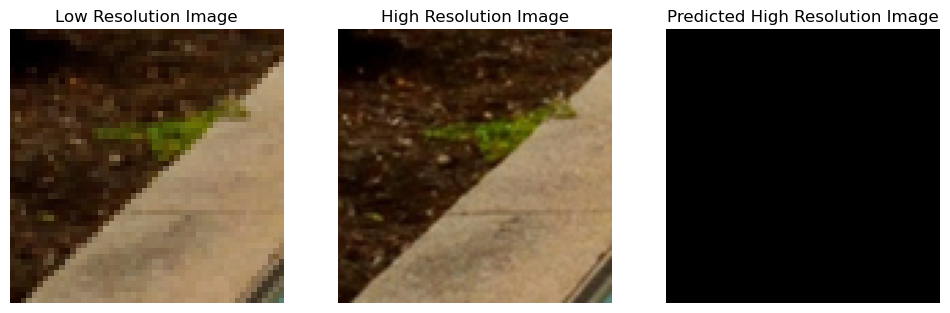

In [6]:
for i in range(BATCH_SIZE):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 3, 1)
    plt.title('Low Resolution Image')
    plt.imshow(x_samples[i])
    plt.axis('off')


    plt.subplot(1, 3, 2)
    plt.title('High Resolution Image')
    plt.imshow(y_samples[i])
    plt.axis('off')


    plt.subplot(1, 3, 3)
    plt.title('Predicted High Resolution Image')
    plt.imshow(y_pred[i])
    plt.axis('off')